# Report Classification Task
## Dataset description
We dropped the classification dataset from project 0, as it had genome sequences as only factors, as we want to focus on coding we strived for an easier to understand set of input variables.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

### Heart Attack Analysis & Prediction Dataset
The dataset's objective is to predict the likelihood of a heart attack, where the target variable distinguishes between lower risk (0) and higher risk (1).
This dataset of 10 features, excluding the target, includes:
Categorical Variables: These include Sex, exang (exercise-induced angina), fbs (fasting blood sugar), and rest_ecg (electrocardiographic results).
Ordinal Variables: cp (chest pain type) and ca (number of major vessels), both of which imply a ranked order of severity or count.
Numerical Variables: Continuous measurements such as Age, trtbps (resting blood pressure), chol (cholesterol level), and thalach (maximum heart rate achieved).

For each numerical column, we calculate the Interquartile Range (IQR) and use it to determine outliers as values lying outside 1.5 times the IQR from the first and third quartiles.

First 5 rows of the dataset:
    age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  

Missing values per variable:
 age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Summary statistics:
               age         sex          cp      trtbps        chol         fbs  \
count  303.000000  3

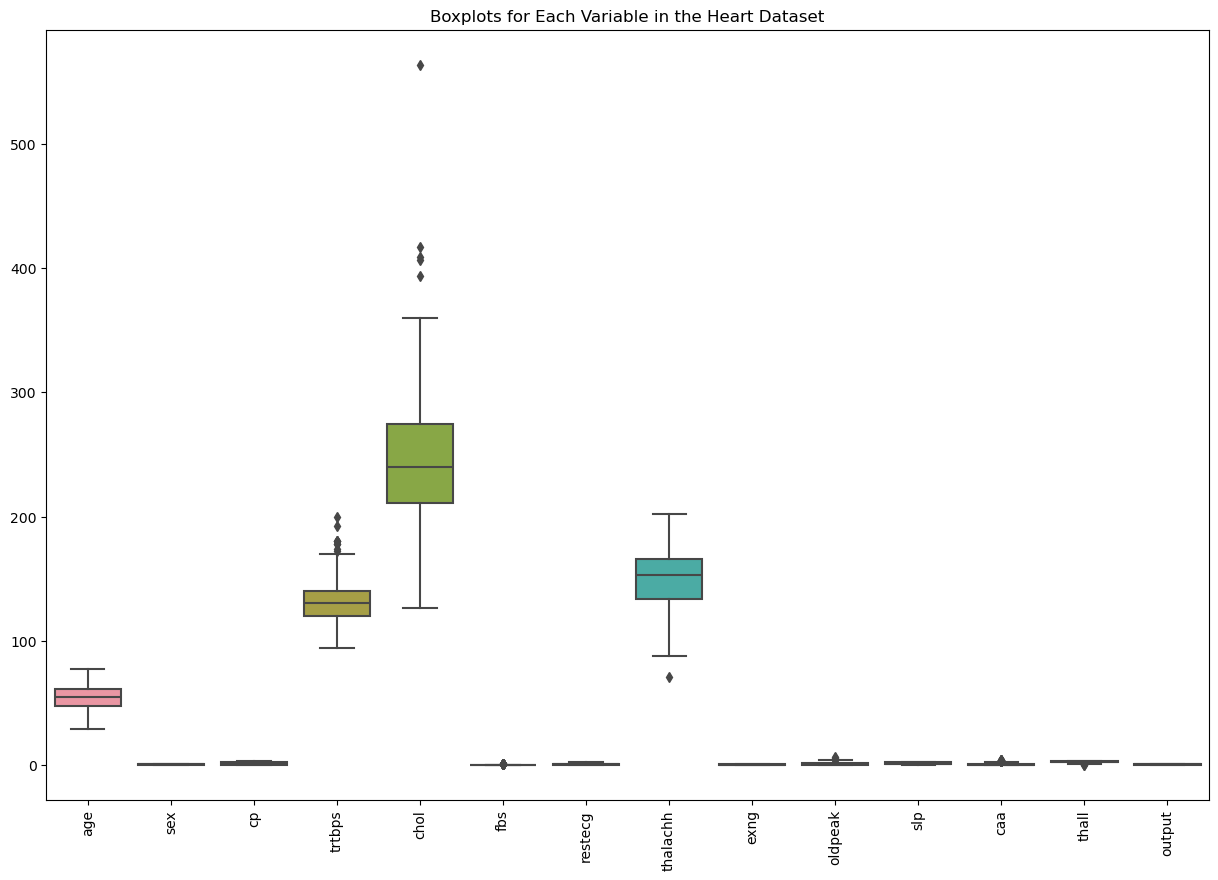

In [ ]:
import seaborn as sns

heart = pd.read_csv("data/heart.csv", sep=',')

print("First 5 rows of the dataset:\n", heart.head())
print("\nMissing values per variable:\n", heart.isna().sum())
print("\nSummary statistics:\n", heart.describe())

#detect outliers using the IQR method
def detect_outliers(df):
    outliers = {}
    for column in df.select_dtypes(include='number').columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers = detect_outliers(heart)

for column, outlier_df in outliers.items():
    print(f"\nOutliers in {column}:\n", outlier_df)

#visualize outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=heart)
plt.xticks(rotation=90)
plt.title("Boxplots for Each Variable in the Heart Dataset")
plt.show() 

To address the varying scales of the continuous variables in the dataset, we applied Min-Max Scaling to normalize the features trtbps (resting blood pressure), thalachh (maximum heart rate achieved), and oldpeak (previous peak) to a [0, 1] range. This transformation standardizes the scale of these variables, allowing them to contribute comparably to the model and improving model performance by reducing the influence of different measurement units.

For the chol (cholesterol) feature, we used Robust Scaling instead of Min-Max Scaling, given that chol contains significant outliers that could disproportionately affect scaling. Robust Scaling relies on the median and interquartile range (IQR), making it less sensitive to extreme values and thus more suitable for this variable. By using this scaling method for chol, we minimize the impact of outliers while still adjusting the feature to a common scale for improved model performance.

The detected outliers that remain untreated are caa, fbs, and thalachh. The variables caa and fbs are class variables, so they were left as is to preserve their categorical nature and meaningful interpretation. In the case of thalachh, only a single outlier was detected, and it was not particularly extreme as observed in the histogram. Given its minimal impact on the overall distribution, it was deemed unnecessary to apply specific treatment for this outlier, allowing the value to remain in the dataset without distorting scaling or model performance.

First 5 rows of the dataset:
    age  sex  cp    trtbps      chol  fbs  restecg  thalachh  exng   oldpeak  \
0   63    1   3  0.481132 -0.110236    1        0  0.603053     0  0.370968   
1   37    1   2  0.339623  0.157480    0        1  0.885496     0  0.564516   
2   41    0   1  0.339623 -0.566929    0        0  0.770992     0  0.225806   
3   56    1   1  0.245283 -0.062992    0        1  0.816794     0  0.129032   
4   57    0   0  0.245283  1.795276    0        1  0.702290     1  0.096774   

   slp  caa  thall  output  
0    0    0      1       1  
1    0    0      2       1  
2    2    0      2       1  
3    2    0      2       1  
4    2    0      2       1  


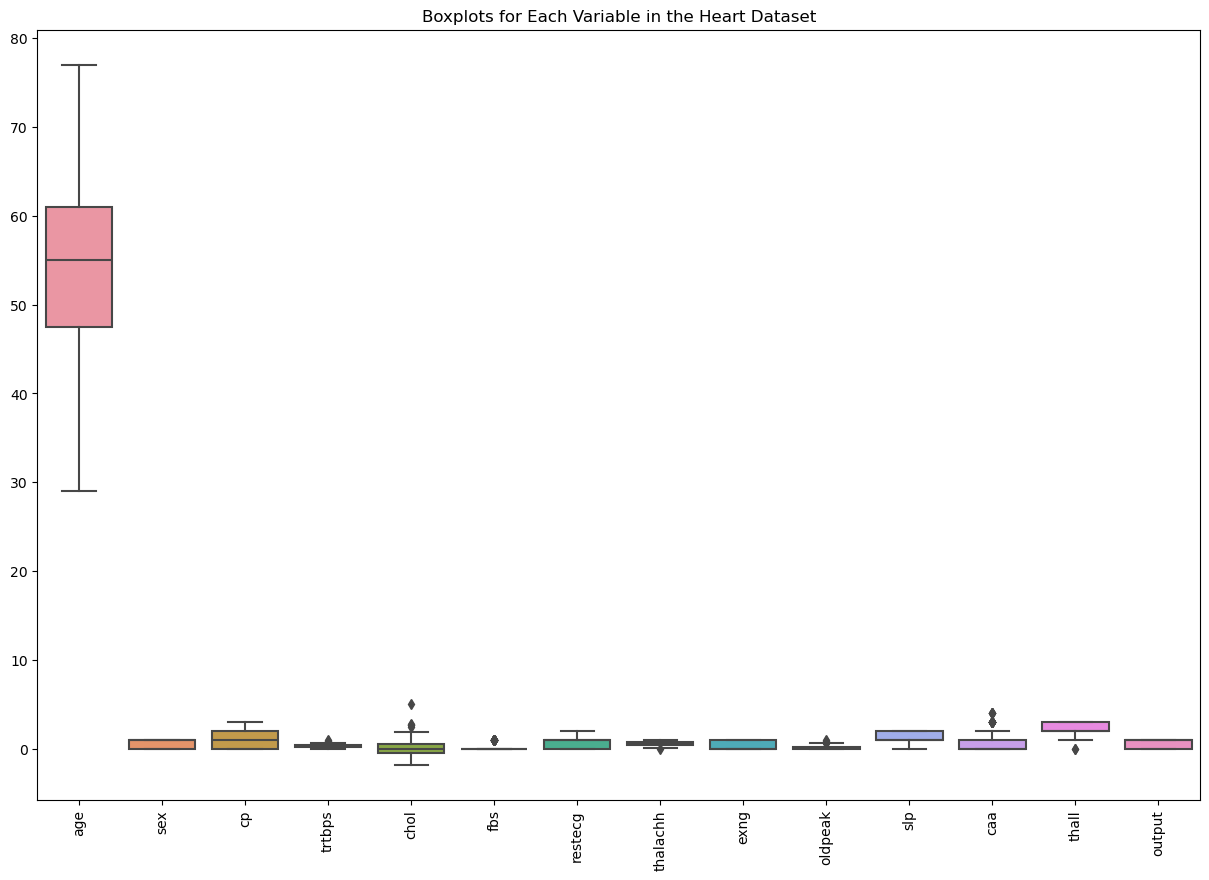

In [38]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
scaler = MinMaxScaler()
heart[['trtbps', 'oldpeak']] = scaler.fit_transform(heart[['trtbps', 'oldpeak']])

scaler = RobustScaler()
heart[['chol']] = scaler.fit_transform(heart[['chol']])

print("First 5 rows of the dataset:\n", heart.head())

#visualize outliers
plt.figure(figsize=(15, 10))
sns.boxplot(data=heart)
plt.xticks(rotation=90)
plt.title("Boxplots for Each Variable in the Heart Dataset")
plt.show()

### Loan

### Flight Status Prediction

### Breast Cancer

In [39]:
heart = pd.read_csv("data\heart.csv", sep=',')